In [1]:
import time
# import IPython
import os
import json
from datetime import datetime
import pyswarm
import pandas

import joblib
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow import keras
import tensorflow.keras.backend as K
from pyswarm import pso


from keras.models import Sequential, Model
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Layer
# from tensorflow.keras import losses
# from keras.utils.vis_utils import plot_model, model_to_dot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

K.set_floatx('float32')

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

tf.enable_v2_behavior()

from tester.tester import Tester

import random

2022-02-14 16:36:56.836860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 16:36:56.836889: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
lb = [2.2, 1.08, -40.]  # lower bounds of the design variables, i.e. input params for the sut_model
ub = [2.8, 1.41, 175.] 
log_path = os.path.join('.','2022_02_02_11_45_57')
log_path

'./2022_02_02_11_45_57'

In [3]:
path = os.path.join(log_path, 'run_stats.txt')
with open(path, 'r') as file:
    run_stats = json.load(file)    

    
num_samples = run_stats['num_samples']
training_proportion = run_stats['training_proportion']
optimization_proportion = 1. - training_proportion

log_std_coefficient = run_stats['log_std_coefficient']
constant_std_coefficient = run_stats['constant_std_coefficient']

run_stats

{'num_samples': 90,
 'training_proportion': 0.4,
 'log_std_coefficient': 4.0,
 'constant_std_coefficient': 10.0}

In [4]:
path = os.path.join(log_path, 'training.npyz')
with open(path, 'rb') as file:
    training_data = np.load(file)
    training_Xs=training_data['points']
    training_ys=training_data['values']
    norm_training_Xs=training_data['norm_points']
    norm_training_ys=training_data['norm_values']
    lls_=training_data['loss']
    amplitude= training_data['amplitude']
    relevances= training_data['relevances']
    noise_var= training_data['noise']
    

In [5]:
path=os.path.join(log_path,'scaler_X.pkl')
transform_X = joblib.load(path)
path=os.path.join(log_path,'scaler_y.pkl')
transform_y = joblib.load(path)


norm_ub = transform_X.transform([ub])[0].astype(np.float32)
norm_lb = transform_X.transform([lb])[0].astype(np.float32)

/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
norm_training_Xs


array([[-6.5746409e-01,  7.9247320e-01,  3.1435958e-01],
       [-1.4335691e+00,  1.1691469e+00,  1.8002299e+00],
       [ 1.4069648e+00,  2.8772721e-01, -2.9525402e-01],
       [-8.0025381e-01, -9.1955401e-03, -1.3617047e+00],
       [ 1.4156972e+00, -1.4581923e-01,  1.5757395e+00],
       [-7.4009560e-02, -6.1279529e-01, -7.6441221e-02],
       [-1.3028796e+00, -1.3552508e-01, -2.1362278e-01],
       [ 1.3602543e+00, -1.1075428e+00, -1.3642615e+00],
       [ 4.2772049e-01, -1.5899147e+00,  5.1299298e-01],
       [-1.6112735e+00,  1.2588590e+00,  5.4188740e-01],
       [ 8.4195518e-01, -1.3057866e+00, -1.4391132e-01],
       [ 9.3965244e-01,  1.0618591e+00,  1.6533769e+00],
       [ 3.4241548e-01, -7.2742063e-01, -6.8281013e-01],
       [ 2.4771629e-01, -5.1306891e-01,  1.1951725e+00],
       [ 1.1934350e+00,  1.4929132e+00, -5.3798890e-01],
       [-8.9138126e-01,  1.1031135e+00, -2.2115713e-01],
       [-1.4777659e+00, -7.7756751e-01, -1.2372029e+00],
       [ 9.3503523e-01, -1.6357

In [7]:
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale=1.0)
kernel = tfk.FeatureScaled(kernel, scale_diag=relevances)
gp_model = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=[[1.2353002 , -0.7703848 ,  1.1779659]],
    observation_index_points=norm_training_Xs,
    observations=norm_training_ys,
    observation_noise_variance=noise_var,
    predictive_noise_variance=0.,
    jitter=1e-4)

gp_model.mean()

2022-02-03 13:55:56.056827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-03 13:55:56.056885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 13:55:56.056933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t460slalb): /proc/driver/nvidia/version does not exist
2022-02-03 13:55:56.058694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float32, numpy=-0.70216036>

In [8]:
path = os.path.join(log_path, 'optimization_rounds.npyz')
with open(path, 'rb') as file:
    optimization_data = np.load(file)
    real_values=optimization_data['values']
    real_choices=optimization_data['choices']
    mean_regrets=optimization_data['mean_regrets']


In [9]:
values= transform_y.transform(real_values.reshape(-1,1))
choices= np.array(transform_X.transform(real_choices), dtype=np.float32)
values=np.array(values.flatten(),dtype=np.float32)


In [10]:
with open('./validation_samples.csv', newline='') as csvfile:
    reader = pandas.read_csv(csvfile,delimiter=';')

    

In [11]:
real_values

array([1.1358706, 1.1368585, 1.1351925, 1.1358836, 1.1360306, 1.1358907,
       1.1360339, 1.1364375, 1.1354318, 1.1368771, 1.1355588, 1.1351693,
       1.1355171, 1.1366564, 1.1355258, 1.1364679, 1.1351839, 1.1355072,
       1.1367997, 1.1362889, 1.1356931, 1.1361024, 1.1364578, 1.1362821,
       1.1356711, 1.1364207, 1.13606  , 1.135202 , 1.1364651, 1.1368988,
       1.1362838, 1.1363529, 1.1360463, 1.1361046, 1.1366583, 1.1357262,
       1.1369414, 1.1357428, 1.1357831, 1.136063 , 1.1362301, 1.1356227,
       1.1358867, 1.13674  , 1.1357781, 1.1356245, 1.1360408, 1.1358778,
       1.1364481, 1.135764 , 1.1357431, 1.1368895, 1.1366053, 1.1364717],
      dtype=float32)

In [12]:
nom_cols =(reader['corner']=='nom') & (reader['Parameter Label']=='V_ref_1v133_untrimmed')
validation_frame= reader[nom_cols]
validation_frame


,Parameter Label,Pattern,Run,Measurement Name,corner,p_vdda_evr,p_vdda_hpbg,p_vddpd,p_vref,p_vss,temperature,trimbg,trimcur,Unnamed: 13,Value,MC Mean,MC Stddev,Cp,Cpk,Unit
4860,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0001,V_ref_1v133_untrimmed,nom,2.2,2.2,1.08,0.6,0,-40,64,16,NaN,1.136468,,,,,V
4861,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0002,V_ref_1v133_untrimmed,nom,2.2,2.2,1.12,0.6,0,-40,64,16,NaN,1.136453,,,,,V
4862,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0003,V_ref_1v133_untrimmed,nom,2.2,2.2,1.16,0.6,0,-40,64,16,NaN,1.136481,,,,,V
4863,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0004,V_ref_1v133_untrimmed,nom,2.2,2.2,1.20,0.6,0,-40,64,16,NaN,1.136483,,,,,V
4864,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0005,V_ref_1v133_untrimmed,nom,2.2,2.2,1.24,0.6,0,-40,64,16,NaN,1.136455,,,,,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0968,V_ref_1v133_untrimmed,nom,2.8,2.8,1.24,0.6,0,175,64,16,NaN,1.135183,,,,,V
5828,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0969,V_ref_1v133_untrimmed,nom,2.8,2.8,1.28,0.6,0,175,64,16,NaN,1.135178,,,,,V
5829,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0970,V_ref_1v133_untrimmed,nom,2.8,2.8,1.32,0.6,0,175,64,16,NaN,1.135178,,,,,V
5830,V_ref_1v133_untrimmed,hpbg_startup_trimall2,RUN0971,V_ref_1v133_untrimmed,nom,2.8,2.8,1.36,0.6,0,175,64,16,NaN,1.135173,,,,,V


In [13]:
valid_real_ys=[]
valid_real_Xs=[]
for index, row in validation_frame.iterrows():
    valid_real_ys.append(row['Value'])
    valid_real_Xs.append([row['p_vdda_evr'], row['p_vddpd'], row['temperature']])

# print(valid_real_Xs)
valid_norm_Xs=np.array(transform_X.transform(valid_real_Xs),dtype=np.float32)
valid_norm_Xs
print(valid_real_ys)

[1.13646789, 1.13645325, 1.13648089, 1.13648258, 1.13645458, 1.13645301, 1.13647462, 1.13646639, 1.13643748, 1.13661531, 1.1366072, 1.13662177, 1.13661863, 1.13660614, 1.13659826, 1.13662052, 1.1366148, 1.13660531, 1.13674418, 1.13675191, 1.13675407, 1.13674355, 1.1367403, 1.13673621, 1.13675145, 1.13674468, 1.13673833, 1.13686901, 1.13689022, 1.13688788, 1.1368802, 1.13687515, 1.13687654, 1.13688254, 1.13688035, 1.13686748, 1.13691227, 1.13692429, 1.13693071, 1.13691271, 1.13692251, 1.1369193, 1.13691801, 1.13691637, 1.13691038, 1.13694765, 1.13695589, 1.13695127, 1.136933, 1.1369461, 1.13694967, 1.13694559, 1.13694857, 1.13693119, 1.13692468, 1.13691953, 1.13692946, 1.13690486, 1.13692096, 1.13692047, 1.13692173, 1.13691878, 1.13689816, 1.13683329, 1.13683392, 1.13683323, 1.13684512, 1.13683316, 1.13683015, 1.13683802, 1.13683841, 1.1368365, 1.13669924, 1.13670199, 1.13668985, 1.13670191, 1.1366932, 1.13668845, 1.13668786, 1.13668694, 1.13668736, 1.13648463, 1.13650024, 1.13648744, 1

In [14]:
opt_norm_Xs=norm_training_Xs.tolist()
opt_norm_ys=norm_training_ys.tolist()


In [15]:

print(len(norm_training_Xs.tolist()))
print(len(opt_norm_Xs))
print(len(opt_norm_ys))
print(len(choices))
print(len(values))


36
36
36
54
54


In [16]:
max_sample=[]
errs=[]
smerrs=[]
total_errs=[]

pred_points=[]
pred_vals=[]

for i in range((len(choices))):

    opt_norm_Xs.append(choices[i])
    opt_norm_ys.append(values[i])

    gp_model = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=valid_norm_Xs,
        observation_index_points=opt_norm_Xs,
        observations=opt_norm_ys,
        observation_noise_variance=noise_var,
        predictive_noise_variance=0.,
        jitter=1e-4)
    pred_norm_ys = gp_model.mean().numpy()
    pred_real_ys = transform_y.inverse_transform(pred_norm_ys.reshape(-1,1)).flatten()

    valid_errs = pred_real_ys - valid_real_ys
    total_errs.append(valid_errs)
    errs.append(np.amax(valid_errs))
    sqvalid_errs = np.square(valid_errs)
    smerrs.append(np.sqrt(np.mean(sqvalid_errs)))
    max_sample.append(transform_y.inverse_transform(np.array([max(opt_norm_ys)])))
    
    # Predicted Maximum
    
#     if (i+1)%9== 0:
#         @tf.function(autograph=False, experimental_compile=False)
#         def eval_model(x):
#             gp_model = tfd.GaussianProcessRegressionModel(
#                 kernel=kernel,
#                 index_points=[x],
#                 observation_index_points=opt_norm_Xs,
#                 observations=opt_norm_ys,
#                 observation_noise_variance=noise_var,
#                 predictive_noise_variance=0.,
#                 jitter=1e-4)   
            
#             return gp_model.mean()
        
#         pred_point, pred_value = pso(func=lambda x: -eval_model(np.float32(x)), lb=norm_lb, ub=norm_ub, maxiter=50,
#                             debug=False)
#         norm_point = transform_X.inverse_transform([pred_point])[0].astype(np.float32)
#         norm_val = transform_y.inverse_transform([-pred_value])[0].astype(np.float32)
        
#         pred_points.append(norm_point)
#         pred_vals.append(norm_val)
        
    ##
    
max_sample=np.array(max_sample)
max_sample=max_sample.flatten()



In [2]:


# filepath = os.path.join('.', 'predicted_optimums90.npyz')
# to_save = {
#     'values': pred_vals,
#     'choices': pred_points,
# }

# with open(filepath, 'wb') as file:
#     np.savez(file, **to_save)
    
    
# with open(filepath, 'rb') as file:
#     data = np.load(file)
#     print(data['choices'])
#     print(data['values'])

    

NameError: name 'lb' is not defined

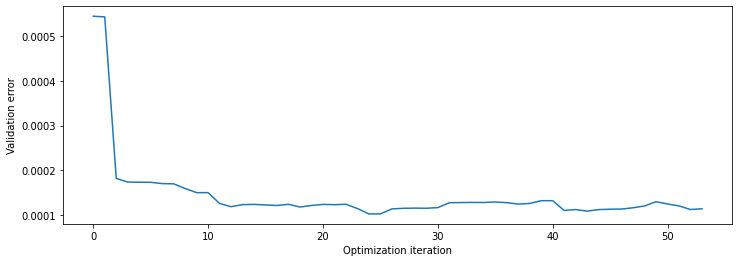

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(errs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('max_loss.pdf',format='pdf',dpi=1200)

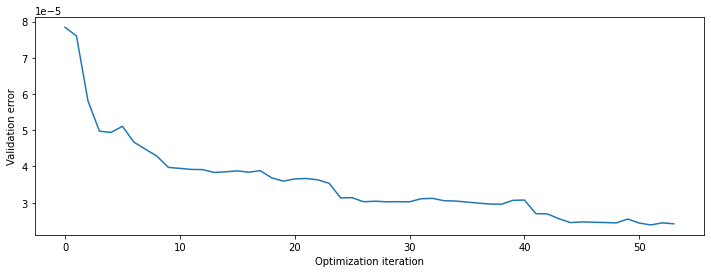

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(smerrs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('sme.pdf',format='pdf',dpi=1200)

array([1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13690817, 1.13690817, 1.13690817, 1.13690817,
       1.13690817, 1.13694143, 1.13694143, 1.13694143, 1.13694143,
       1.13694143, 1.13694143, 1.13694143, 1.13694143, 1.13694143,
       1.13694143, 1.13694143, 1.13694143, 1.13694143, 1.13694143,
       1.13694143, 1.13694143, 1.13694143, 1.13694143])

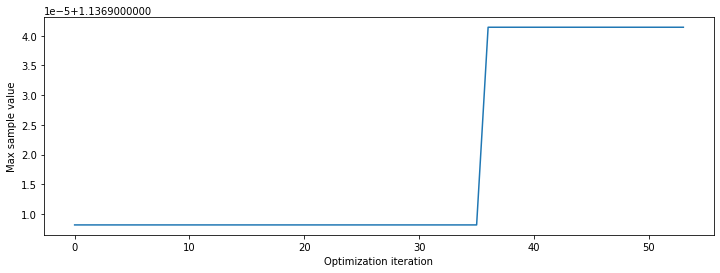

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(max_sample)
plt.xlabel("Optimization iteration")
plt.ylabel("Max sample value")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('max.pdf',format='pdf',dpi=1200)
max_sample